# Aula 02: Redes Neurais Recorrentes
* Exemplo de uma RNN Clássica
* Testando a normalização pela média e desvio-padrão



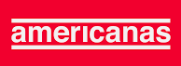

## Objetivos:
* Previsão do valor de uma ação: caso Americas AMER3.SA;
* Fonte de dados: Yahoo Finance: https://tinyurl.com/mphcy6c6;
* Entender o processo de extração de dados e pré-processamento de uma RNN;
* Entender as métricas que podem ser utilizadas para esse problema;
* Testar diferentes formas de normalização de dados;

## Importação e instalação das bibliotecas

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import math

# utilizada para obter os dados das ações
import yfinance as yf

from sklearn.metrics import (mean_squared_error, 
  mean_absolute_error, 
  mean_absolute_percentage_error, 
  roc_curve, confusion_matrix, 
  accuracy_score, 
  f1_score) # métricas
  
from sklearn.preprocessing import MinMaxScaler  # usado na etapa de normalização de dados

In [86]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [87]:
# bibliotecas para rodar o modelo RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, Precision, Recall

In [88]:
# Definição de cores para gráficos
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Análise e pré-processamendo dos dados

### Carregamento de dados

In [89]:
# baixando os valores das ações da Americanas

ticker = 'AMER3.SA'
start_date = '2005-03-30'
end_date = '2023-03-30'

df_data_download = yf.download(ticker, start=start_date, end=end_date)

df_data_download.head(-5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-03-30,20.400707,20.400707,18.899357,19.093649,18.397429,6428031
2005-03-31,19.243784,19.243784,17.309690,19.093649,18.397429,4726164
2005-04-01,19.093649,19.429245,18.457783,18.546097,17.869844,805075
2005-04-04,18.104523,18.192839,16.832790,17.450994,16.814672,338448
2005-04-05,17.662951,17.662951,17.000589,17.194881,16.567900,419748
...,...,...,...,...,...,...
2023-03-15,1.020000,1.050000,1.000000,1.030000,1.030000,29432000
2023-03-16,1.040000,1.100000,1.040000,1.050000,1.050000,39141700
2023-03-17,1.050000,1.070000,1.030000,1.040000,1.040000,25232500


In [90]:
# criando uma cópia dos dados originais
# stock_mv: Stock Market Value
df_stock_mv = df_data_download.copy()
df_stock_mv.shape

(4476, 6)

In [91]:
df_stock_mv.head(-5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-03-30,20.400707,20.400707,18.899357,19.093649,18.397429,6428031
2005-03-31,19.243784,19.243784,17.309690,19.093649,18.397429,4726164
2005-04-01,19.093649,19.429245,18.457783,18.546097,17.869844,805075
2005-04-04,18.104523,18.192839,16.832790,17.450994,16.814672,338448
2005-04-05,17.662951,17.662951,17.000589,17.194881,16.567900,419748
...,...,...,...,...,...,...
2023-03-15,1.020000,1.050000,1.000000,1.030000,1.030000,29432000
2023-03-16,1.040000,1.100000,1.040000,1.050000,1.050000,39141700
2023-03-17,1.050000,1.070000,1.030000,1.040000,1.040000,25232500


### Tratamento do dataset



In [92]:
# verificando e visualizando se há informações vazias ou em branco
# isna(): False se está preenchido e True para não preenchido
# any(axis = 1): se em alguma linha o resultado for True, retorna a linha com info faltantes (NaN por exemplo)

df_stock_mv[df_stock_mv.isna().any(axis = 1)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [93]:
# index nessa importação é a data dos registros

df_stock_mv.columns
print(df_stock_mv.index)

DatetimeIndex(['2005-03-30', '2005-03-31', '2005-04-01', '2005-04-04',
               '2005-04-05', '2005-04-06', '2005-04-07', '2005-04-08',
               '2005-04-11', '2005-04-12',
               ...
               '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-20',
               '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24',
               '2023-03-27', '2023-03-28'],
              dtype='datetime64[ns]', name='Date', length=4476, freq=None)


In [94]:
# descarta alguma linha que possui em algum valor faltante
df_stock_mv = df_stock_mv.dropna()

In [95]:
len(df_stock_mv)

4476

In [96]:
# faremos a previsão utilizando apenas o valor de fechamento da ação!
# modelo para fins didáticos, não deverá ser usado para análise de compra/venda de ativos
closed_value_stock = df_stock_mv['Close'].values
print(closed_value_stock)

[19.09364891 19.09364891 18.5460968  ...  1.01999998  1.00999999
  1.00999999]


### Visualizando os dados de entrada

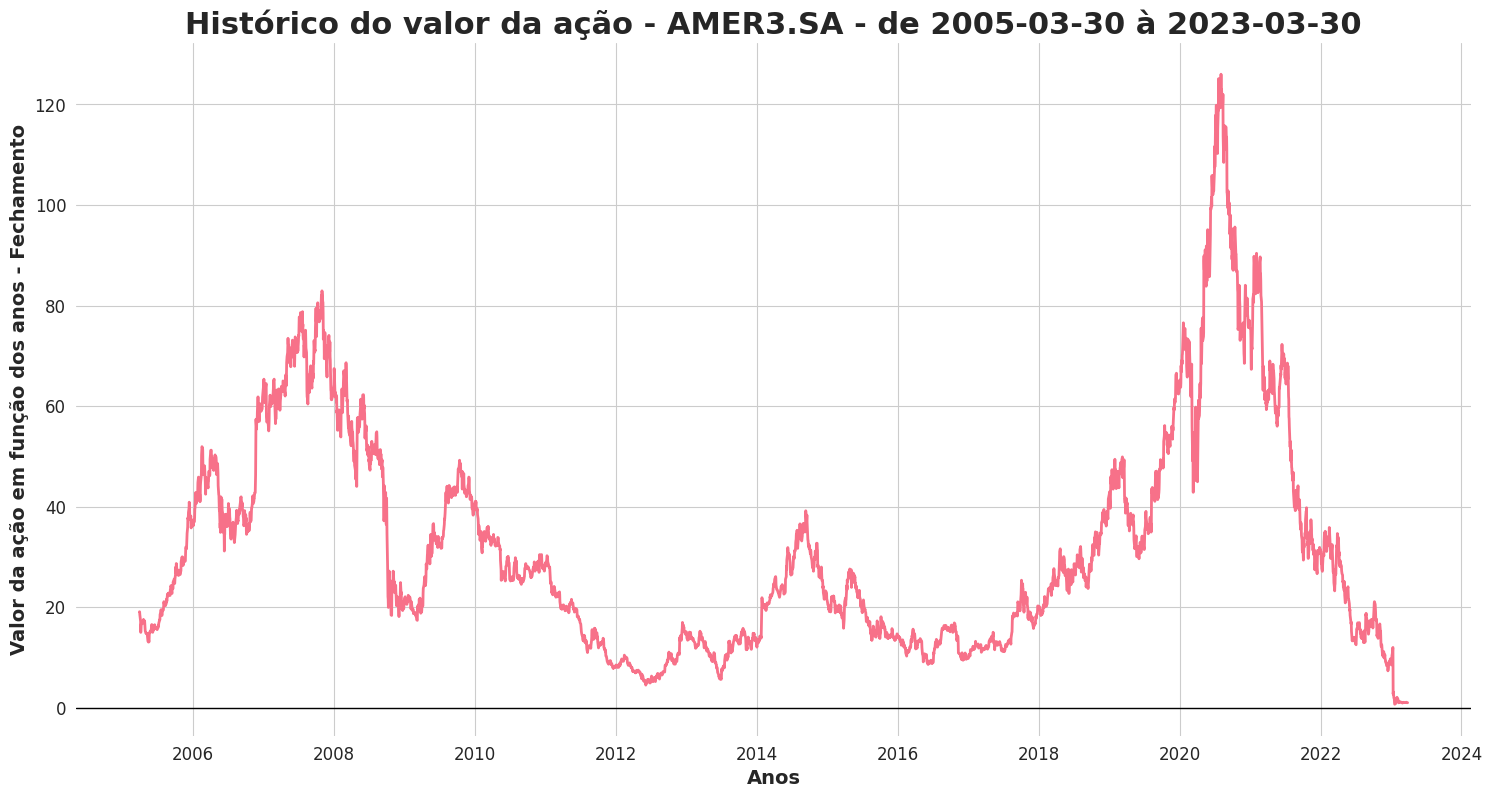

In [97]:
# Defina o estilo do Seaborn e a paleta de cores
sns.set_style("whitegrid")
sns.set_palette("husl")

# Crie a figura e o eixo
fig, ax = plt.subplots(figsize=(18, 9))

# Plote o gráfico
ax.plot(df_stock_mv['Close'], linewidth=2)

# Personalize os rótulos dos eixos e o título
ax.set_xlabel('Anos', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor da ação em função dos anos - Fechamento', fontsize=14, fontweight='bold')
ax.set_title(f'Histórico do valor da ação - {ticker} - de {start_date} à {end_date}', fontsize=22, fontweight='bold')

# Personalize as marcas dos eixos
ax.tick_params(axis='both', labelsize=12)

# Adicione uma linha horizontal em y=0 para melhorar a visualização
ax.axhline(y=0, color='black', linewidth=1)

# Remova as bordas do gráfico
sns.despine(left=True, bottom=True)

# Exiba o gráfico
plt.show()

### Preparando os dados de Teste e de Treino

In [98]:
# define o intervalo anterior para a estimativa
# pode ser qualquer valor.
# o algoritmo é mais sensível para previsão com os últimos dados

days_time_step = 15

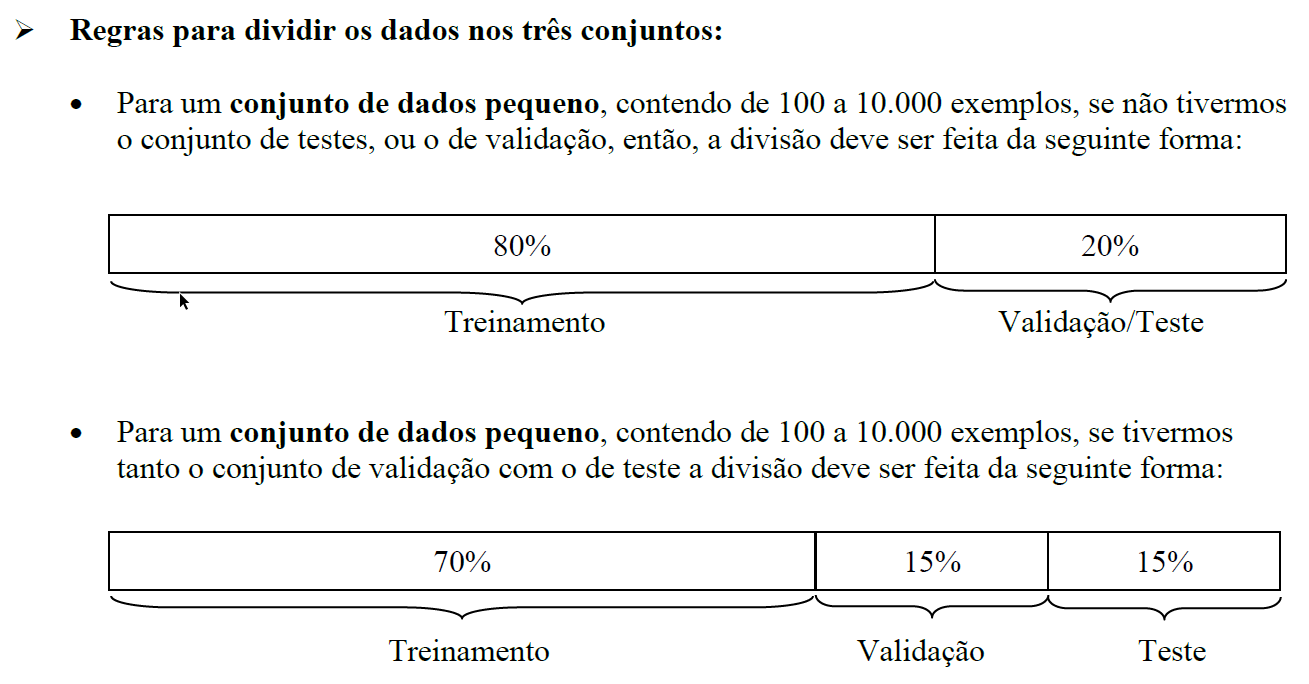

### Divisão do conjunto de dados

In [99]:
# de acordo com a tabela acima, faremos a divisão 80%/20%:
training_size = int(len(closed_value_stock) * 0.80)

# em uma RNN, a ordem dos elementos é essencial para a relação de recorrência
# train_data e test_data não estão normalizados
train_data = closed_value_stock[:training_size]
test_data = closed_value_stock[training_size:]

train_data.shape, test_data.shape

((3580,), (896,))

### Visualizando os dados de teste antes da normalização
* apenas uma verificação secundária


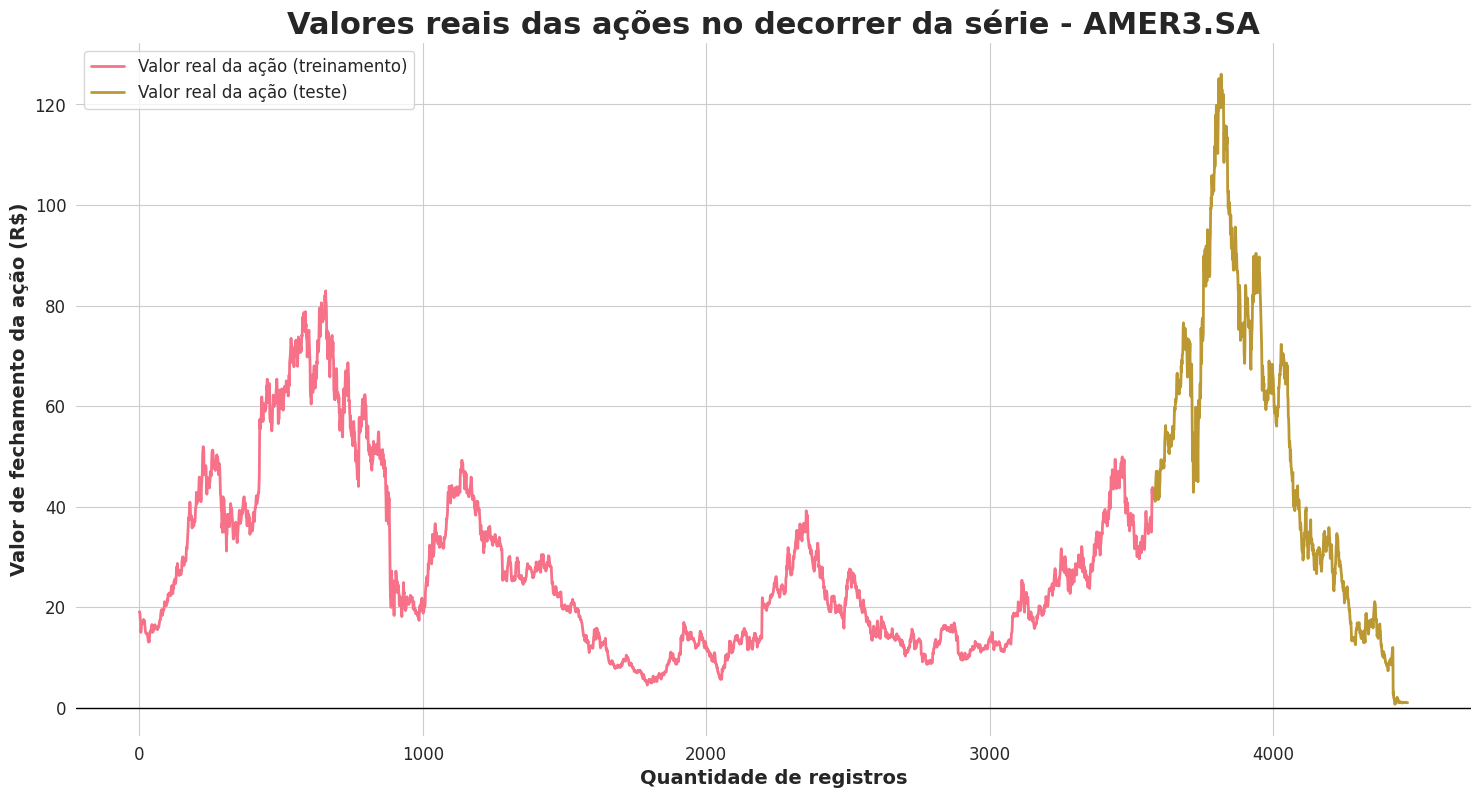

In [100]:
# Defina o estilo do Seaborn e a paleta de cores
sns.set_style("whitegrid")
sns.set_palette("husl")

# Define os índices para os dados de treinamento e teste
train_index = range(0, len(train_data))
test_index = range(len(train_data), len(train_data) + len(test_data))

# Crie a figura e o eixo
fig, ax = plt.subplots(figsize=(18, 9))

# Plote os dados de treinamento e teste
ax.plot(train_index, train_data, label='Valor real da ação (treinamento)', linewidth=2)
ax.plot(test_index, test_data, label='Valor real da ação (teste)', linewidth=2)

# Personalize os rótulos dos eixos e o título
ax.set_xlabel('Quantidade de registros', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor de fechamento da ação (R$)', fontsize=14, fontweight='bold')
ax.set_title(f'Valores reais das ações no decorrer da série - {ticker}', fontsize=22, fontweight='bold')

# Personalize as marcas dos eixos
ax.tick_params(axis='both', labelsize=12)

# Adicione uma linha horizontal em y=0 para melhorar a visualização
ax.axhline(y=0, color='black', linewidth=1)

# Adicione legendas
ax.legend(fontsize=12)

# Remova as bordas do gráfico
sns.despine(left=True, bottom=True)

# Exiba o gráfico
plt.show()

### Normalização dos dados
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [101]:
from sklearn.preprocessing import StandardScaler

# criando o objeto StandardScaler
scaler = StandardScaler()

# Ajuste e transforme os dados de entrada usando média e desvio-padrão
closed_value_stock_norm = scaler.fit_transform(closed_value_stock.reshape(-1, 1))

closed_value_stock_norm

array([[-0.58506808],
       [-0.58506808],
       [-0.60940665],
       ...,
       [-1.38843773],
       [-1.38888222],
       [-1.38888222]])

### Normalização dos conjuntos de treino e teste

In [102]:
# em uma RNN, a ordem dos elementos é essencial para a relação de recorrência 
train_data = closed_value_stock_norm[:training_size]
test_data = closed_value_stock_norm[training_size:]

train_data.shape, test_data.shape

((3580, 1), (896, 1))

### Visualizando os dados de teste normalizados

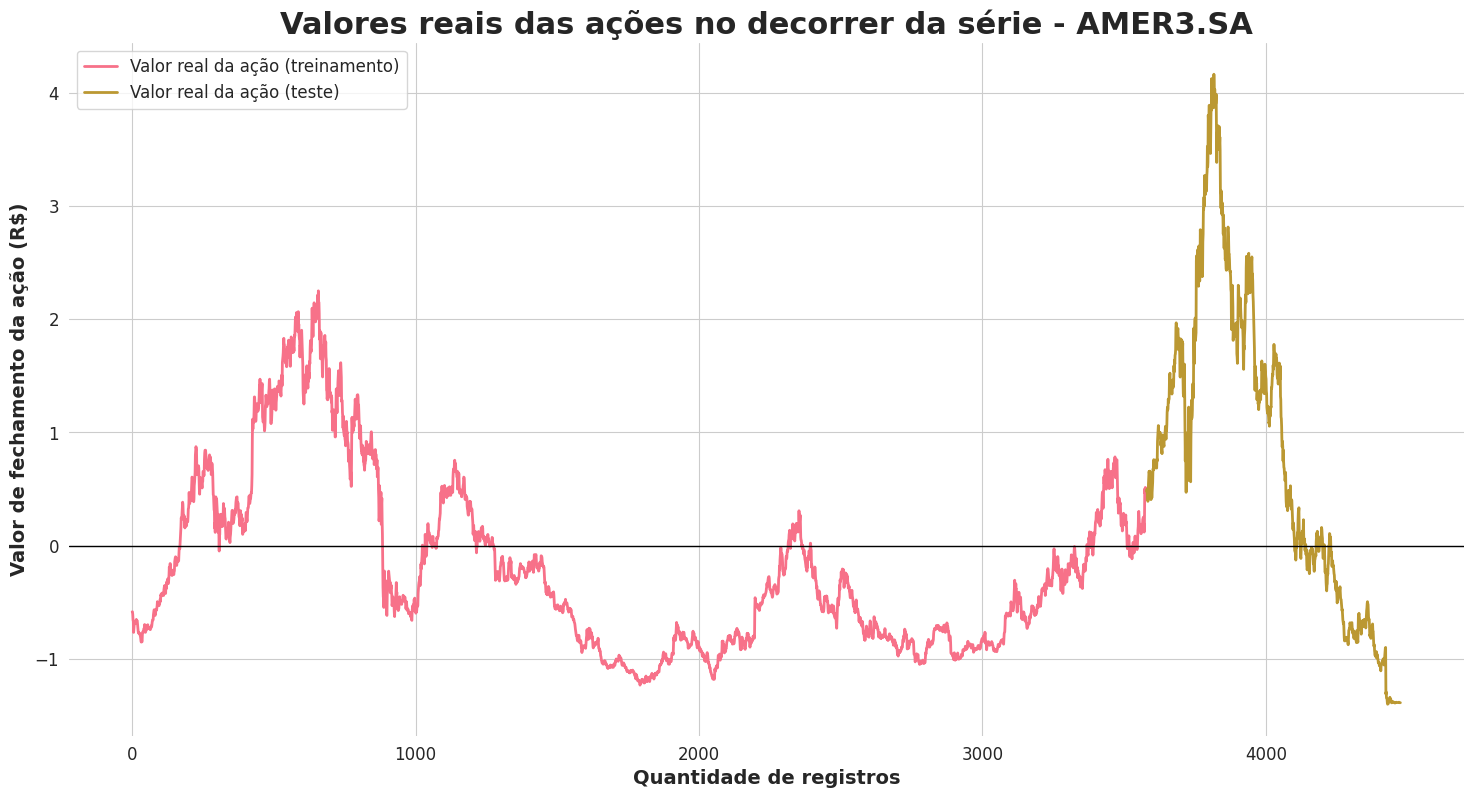

In [103]:
# Defina o estilo do Seaborn e a paleta de cores
sns.set_style("whitegrid")
sns.set_palette("husl")

# Define os índices para os dados de treinamento e teste
train_index = range(0, len(train_data))
test_index = range(len(train_data), len(train_data) + len(test_data))

# Crie a figura e o eixo
fig, ax = plt.subplots(figsize=(18, 9))

# Plote os dados de treinamento e teste
ax.plot(train_index, train_data, label='Valor real da ação (treinamento)', linewidth=2)
ax.plot(test_index, test_data, label='Valor real da ação (teste)', linewidth=2)

# Personalize os rótulos dos eixos e o título
ax.set_xlabel('Quantidade de registros', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor de fechamento da ação (R$)', fontsize=14, fontweight='bold')
ax.set_title(f'Valores reais das ações no decorrer da série - {ticker}', fontsize=22, fontweight='bold')

# Personalize as marcas dos eixos
ax.tick_params(axis='both', labelsize=12)

# Adicione uma linha horizontal em y=0 para melhorar a visualização
ax.axhline(y=0, color='black', linewidth=1)

# Adicione legendas
ax.legend(fontsize=12)

# Remova as bordas do gráfico
sns.despine(left=True, bottom=True)

# Exiba o gráfico
plt.show()

### Pré-processamento

#### Sequências de treino e teste

In [104]:
# função para a criação das sequências de treinamento e teste
def create_sequences_RNN(data, days_time_step):
    X, y = [], []
    for i in range(days_time_step, len(data)):
        X.append(data[i - days_time_step:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [105]:
# criando as sequências de treino e teste - formato NumPy
X_train, y_train = create_sequences_RNN(train_data, days_time_step)
X_test, y_test = create_sequences_RNN(test_data, days_time_step)

In [106]:
# reformatar os dados para o formato necessário pela RNN
# formado: (batch_size, timesteps, input_features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Modelo RNN Clássico e definição de métricas

In [107]:
# adiciona o MSPE no cálculo das métricas usando TF
# MSPE não é uma métrica padrão no TF

class MeanSquaredPercentageError(tf.keras.metrics.Metric):
    def __init__(self, name='mspe', **kwargs):
        super().__init__(name=name, **kwargs)
        self.sum_squared_percentage_error = self.add_weight(name='sum_squared_percentage_error', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        squared_percentage_error = tf.math.squared_difference(y_true, y_pred) / tf.maximum(tf.abs(y_true), 1e-7)
        self.sum_squared_percentage_error.assign_add(tf.reduce_sum(squared_percentage_error))
        self.count.assign_add(tf.cast(tf.size(y_true), dtype=tf.float32))

    def result(self):
        return self.sum_squared_percentage_error / self.count

    def reset_states(self):
        self.sum_squared_percentage_error.assign(0.0)
        self.count.assign(0.0)


In [108]:
####################
UNITS = 100
####################

# Define callback para parada 
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# Escolher as métricas apropriadas para seu problema
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.MeanSquaredError(name='mse'),
    tf.keras.metrics.MeanAbsoluteError(name='mae'),
    tf.keras.metrics.RootMeanSquaredError(name='rmse'),
    MeanSquaredPercentageError(name='mspe')
]

def make_model(METRICS, INPUT_DIM):
    # Configuração da rede
    rnn = Sequential()
    rnn.add(SimpleRNN(units=UNITS, activation='tanh', 
                      input_shape=(INPUT_DIM, 1)))
    rnn.add(Dense(units=1))

    rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=METRICS)

    return rnn

In [109]:
# Determina número de carateríticas
features_shape = X_train.shape[1]
print('Dimensão dos dados de entrada =', features_shape)

# Cria RN já compilada
rnn = make_model(METRICS, features_shape)
rnn.summary()

Dimensão dos dados de entrada = 15
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


### Treinando o modelo

In [110]:
##################
EPOCHS = 10
BATCH_SIZE = 32
##################

# treinando o modelo
history = rnn.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_split=0.2, callbacks=[early_stopping] )

Epoch 1/10
85/90 [===========================>..] - ETA: 0s - loss: 0.0147 - tp: 552.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 2168.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.2029 - auc: 0.0000e+00 - mse: 0.0147 - mae: 0.0827 - rmse: 0.1212 - mspe: 0.0444

/usr/local/lib/python3.9/dist-packages/keras/engine/training.py:2448: UserWarning: Metric MeanSquaredPercentageError implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


90/90 [==============================] - 4s 16ms/step - loss: 0.0143 - tp: 579.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 2273.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.2030 - auc: 0.0000e+00 - mse: 0.0143 - mae: 0.0815 - rmse: 0.1196 - mspe: 0.0435 - val_loss: 0.0040 - val_tp: 47.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 666.0000 - val_accuracy: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.0659 - val_auc: 0.0000e+00 - val_mse: 0.0040 - val_mae: 0.0446 - val_rmse: 0.0633 - val_mspe: 0.0528
Epoch 2/10
90/90 [==============================] - 1s 8ms/step - loss: 0.0047 - tp: 564.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 2288.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.1978 - auc: 0.0000e+00 - mse: 0.0047 - mae: 0.0466 - rmse: 0.0682 - mspe: 0.0237 - val_loss: 0.0033 - val_tp: 51.0000 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 662.0000 - val_accuracy: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.0715 - val_auc: 0.0

In [111]:
# resumo dos resultados do modelo
results = rnn.evaluate(X_test, y_test)
print(dict(zip(rnn.metrics_names, results)))

28/28 [==============================] - 0s 5ms/step - loss: 0.0211 - tp: 473.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 408.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.5369 - auc: 0.0000e+00 - mse: 0.0211 - mae: 0.0867 - rmse: 0.1451 - mspe: 0.0328
{'loss': 0.021054057404398918, 'tp': 473.0, 'fp': 0.0, 'tn': 0.0, 'fn': 408.0, 'accuracy': 0.0, 'precision': 1.0, 'recall': 0.536889910697937, 'auc': 0.0, 'mse': 0.021054057404398918, 'mae': 0.08672693371772766, 'rmse': 0.1451001614332199, 'mspe': 0.03281876817345619}


### Observações sobre as métricas:

Nem todas métricas são importantes para as RNN. Vejamos algumas definições:

- **Falsos negativos** e **falsos positivos** são exemplos classificados **incorretamente**.


* **Verdadeiros negativos** e **verdadeiros positivos** são exemplos classificados **corretamente**.


* **Exatidão ("accuracy")** é a porcentagem de exemplos classificados corretamente:


 $$\frac{\text{exemplos classificados corretamente}}{\text{total de exemplos}}$$
 
 
* **Precisão ("precision")** é a porcentagem de exemplos positivos classificados corretamente:

$$\frac{\text{verdadeiros positivos}}{\text{verdadeiros positivos + falsos positivos}}$$


* **Revocação ("recall")** é a porcentagem de exemplos positivos reais que foram classificados corretamente:


$$\frac{\text{verdadeiros positivos}}{\text{verdadeiros positivos + falsos negativos}}$$


* **AUC** refere-se à área sob uma curva de característica de operação do receptor (ROC-AUC). Essa métrica é igual à probabilidade de que um classificador classifique uma amostra  positiva mais alta do que uma amostra negativa [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)


**Observação**: A métrica RMSE pode ser usada para avaliar a precisão do modelo em prever valores contínuos, como previsões de séries temporais. Enquanto a métrica MSPE pode ser útil para avaliar o desempenho do modelo em prever valores percentuais.

Portanto, é importante escolher as métricas que são mais apropriadas para a tarefa específica e os dados com os quais você está trabalhando. Por exemplo, se você estiver trabalhando com séries temporais com uma grande variação entre valores, o RMSE pode não ser a métrica mais apropriada e pode ser mais adequado usar uma métrica como o MAE (Mean Absolute Error).

## Realizando as previsões

In [112]:
# previsões
y_train_pred = rnn.predict(X_train)
y_test_pred = rnn.predict(X_test)

28/28 [==============================] - 0s 3ms/step


In [113]:
# voltando os resultados para a escala original
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

In [114]:
# raiz do erro quadrático médio (RMSE)

train_rmse = np.sqrt(np.mean(np.square(y_train_pred - scaler.inverse_transform(y_train))))
test_rmse = np.sqrt(np.mean(np.square(y_test_pred - scaler.inverse_transform(y_test))))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

Train RMSE: 1.07
Test RMSE: 3.26


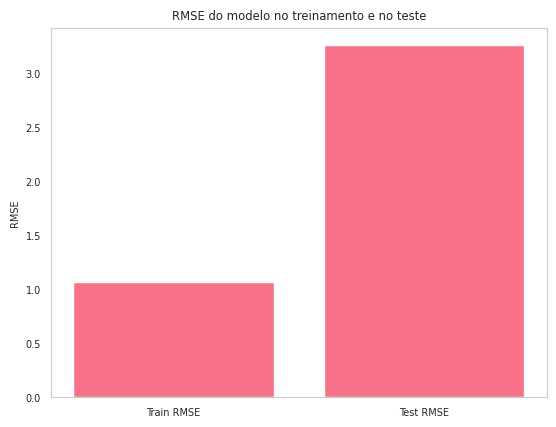

In [115]:
# Crie uma lista com os valores de RMSE e os rótulos correspondentes
rmse_values = [train_rmse, test_rmse]
labels = ['Train RMSE', 'Test RMSE']

# Crie um gráfico de barras para visualizar os valores de RMSE
plt.bar(labels, rmse_values)
plt.ylabel('RMSE')
plt.title('RMSE do modelo no treinamento e no teste')
plt.grid()
plt.show()

## Visualizando os resultados

### Série histórica

In [116]:
# preparação dos dados para plotagem
train_dates = df_data_download.index[:training_size]
test_dates = df_data_download.index[training_size + days_time_step:]

In [117]:
# criando um DF com as previsões e os preços reais
train_df = pd.DataFrame({"Real": scaler.inverse_transform(y_train).reshape(-1), \
                         "Predicted": y_train_pred.reshape(-1)}, index=train_dates[days_time_step:])
test_df = pd.DataFrame({"Real": scaler.inverse_transform(y_test).reshape(-1), \
                        "Predicted": y_test_pred.reshape(-1)}, index=test_dates)

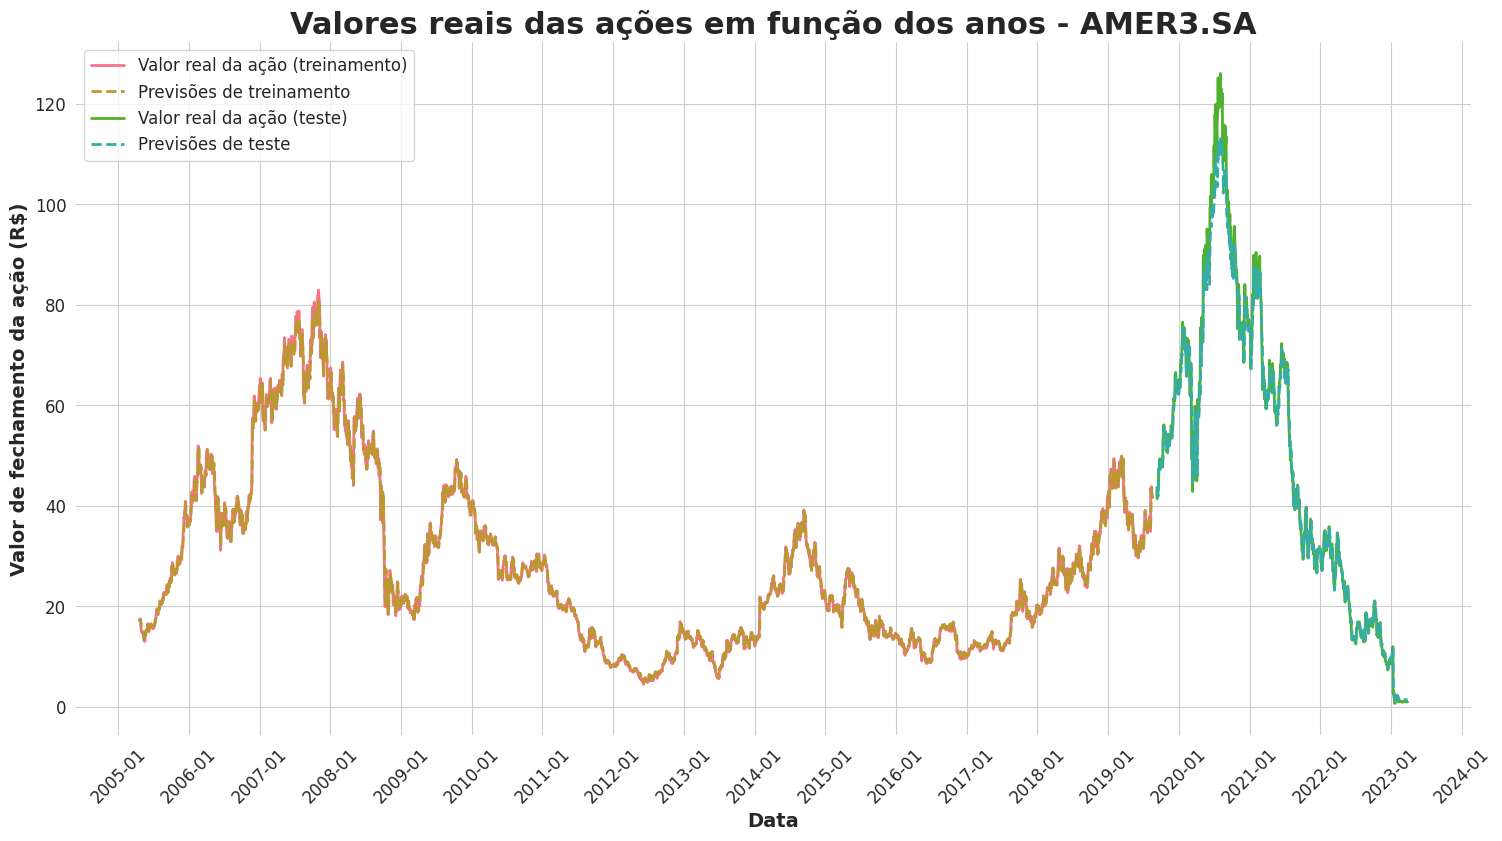

In [118]:
# Defina o estilo do Seaborn e a paleta de cores
sns.set_style("whitegrid")
sns.set_palette("husl")

# Crie a figura e o eixo
fig, ax = plt.subplots(figsize=(18, 9))

# Plote os resultados
ax.plot(train_df['Real'], label='Valor real da ação (treinamento)', linewidth=2)
ax.plot(train_df['Predicted'], label='Previsões de treinamento', linewidth=2, linestyle='dashed')
ax.plot(test_df['Real'], label='Valor real da ação (teste)', linewidth=2)
ax.plot(test_df['Predicted'], label='Previsões de teste', linewidth=2, linestyle='dashed')

# Personalize os rótulos dos eixos e o título
ax.set_xlabel('Data', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor de fechamento da ação (R$)', fontsize=14, fontweight='bold')
ax.set_title(f'Valores reais das ações em função dos anos - {ticker}', fontsize=22, fontweight='bold')

# Personalize as marcas dos eixos
ax.tick_params(axis='both', labelsize=12)

# Formatar eixos
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator())

# Incline os rótulos do eixo x em 45 graus
plt.xticks(rotation=45)

# Adicione legendas
ax.legend(fontsize=12)

# Remova as bordas do gráfico
sns.despine(left=True, bottom=True)

# Exiba o gráfico
plt.show()


### Conjunto de Treino vs. Teste

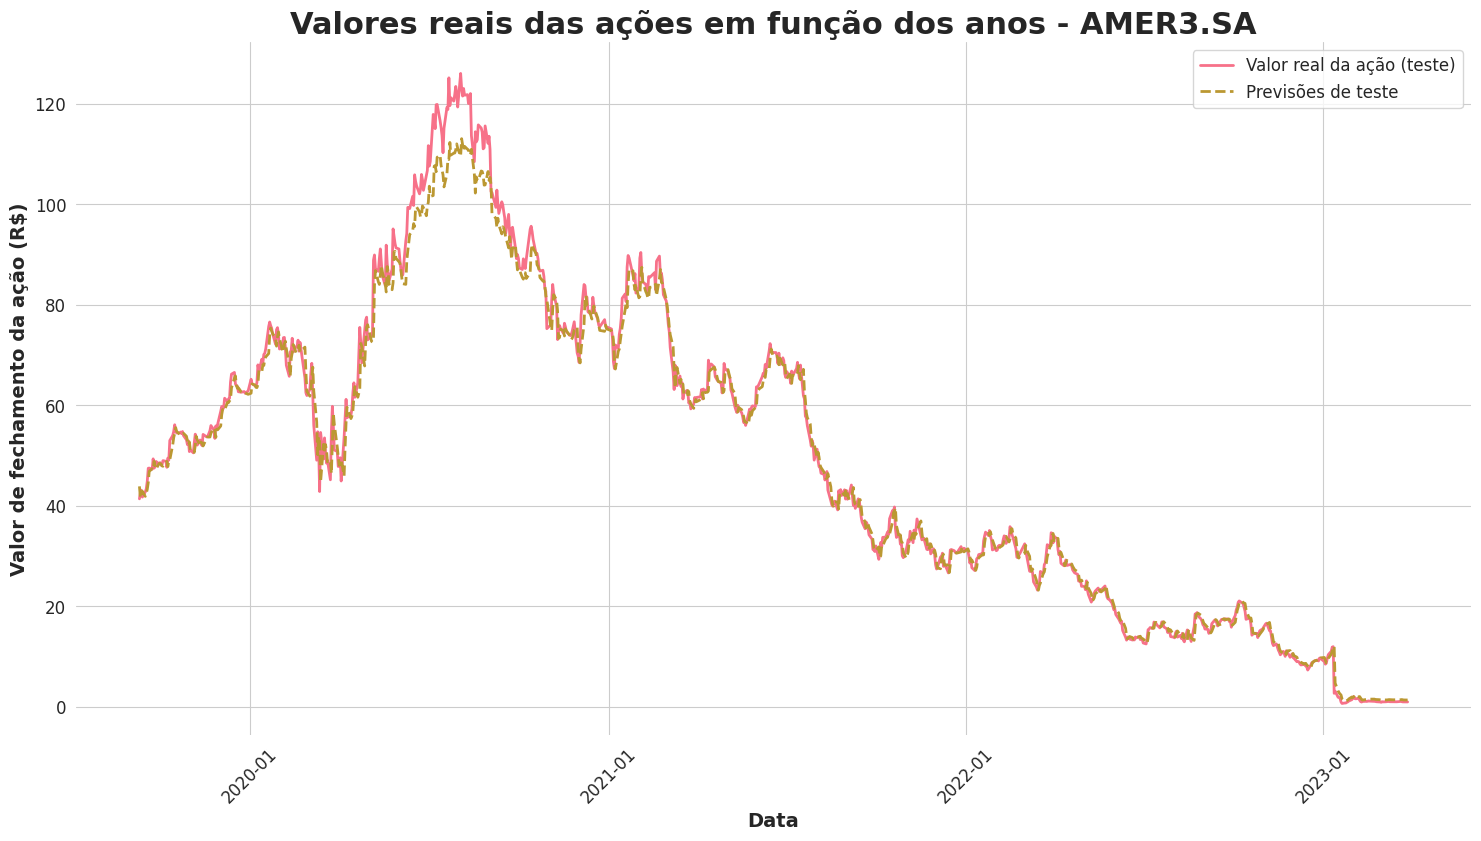

In [119]:
# Defina o estilo do Seaborn e a paleta de cores
sns.set_style("whitegrid")
sns.set_palette("husl")

# Crie a figura e o eixo
fig, ax = plt.subplots(figsize=(18, 9))

# Plote os resultados
ax.plot(test_df['Real'], label='Valor real da ação (teste)', linewidth=2)
ax.plot(test_df['Predicted'], label='Previsões de teste', linewidth=2, linestyle='dashed')

# Personalize os rótulos dos eixos e o título
ax.set_xlabel('Data', fontsize=14, fontweight='bold')
ax.set_ylabel('Valor de fechamento da ação (R$)', fontsize=14, fontweight='bold')
ax.set_title(f'Valores reais das ações em função dos anos - {ticker}', fontsize=22, fontweight='bold')

# Personalize as marcas dos eixos
ax.tick_params(axis='both', labelsize=12)

# Formatar eixos
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator())

# Incline os rótulos do eixo x em 45 graus
plt.xticks(rotation=45)

# Adicione legendas
ax.legend(fontsize=12)

# Remova as bordas do gráfico
sns.despine(left=True, bottom=True)

# Exiba o gráfico
plt.show()


## Métricas

In [120]:
# Métricas do TF
results = rnn.evaluate(X_test, y_test)
print(dict(zip(rnn.metrics_names, results)))

28/28 [==============================] - 0s 6ms/step - loss: 0.0211 - tp: 473.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 408.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.5369 - auc: 0.0000e+00 - mse: 0.0211 - mae: 0.0867 - rmse: 0.1451 - mspe: 0.0328


/usr/local/lib/python3.9/dist-packages/keras/engine/training.py:2448: UserWarning: Metric MeanSquaredPercentageError implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


{'loss': 0.021054057404398918, 'tp': 473.0, 'fp': 0.0, 'tn': 0.0, 'fn': 408.0, 'accuracy': 0.0, 'precision': 1.0, 'recall': 0.536889910697937, 'auc': 0.0, 'mse': 0.021054057404398918, 'mae': 0.08672693371772766, 'rmse': 0.1451001614332199, 'mspe': 0.03281876817345619}


### MSE

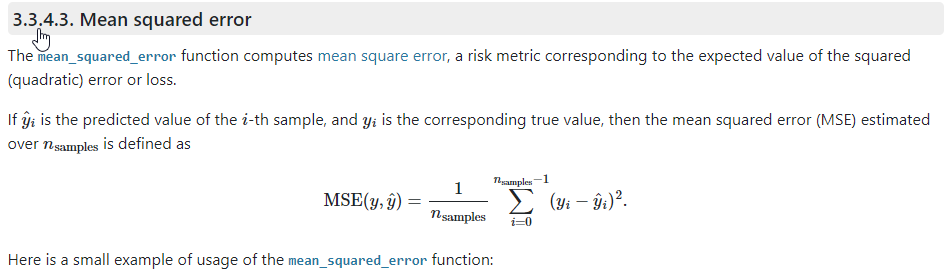

### MAE

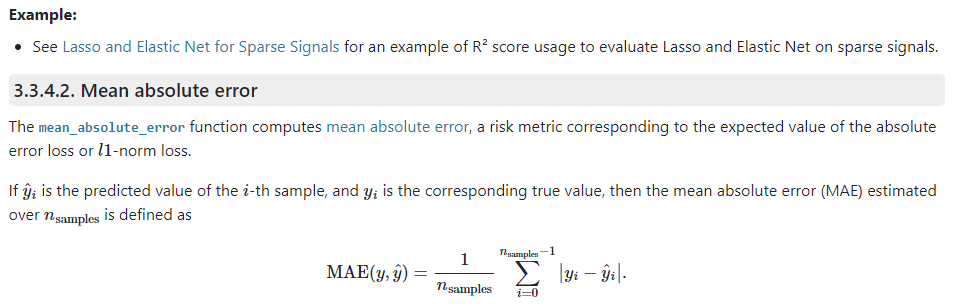

### MAPE

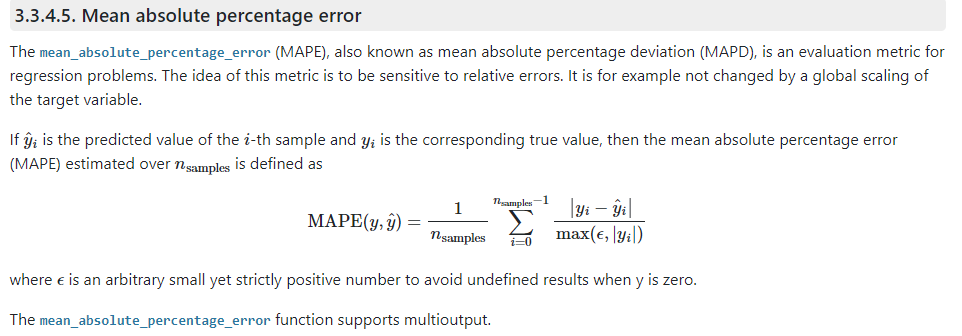

### RMSE

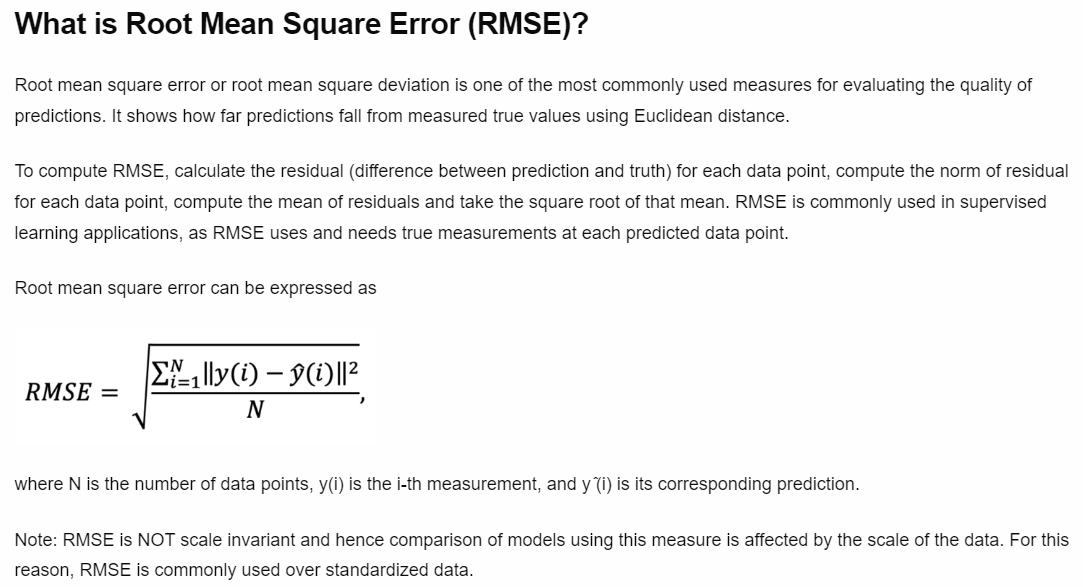

### Análises gráficas

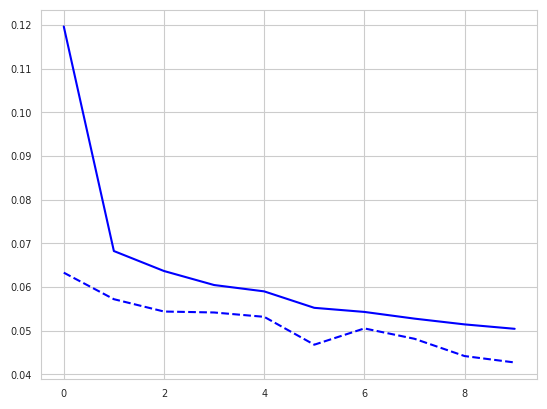

In [121]:
plt.plot(history.history['rmse'], label='Training RMSE', color='blue')
plt.plot(history.history['val_rmse'], label='Validation RMSE', color='blue', linestyle='--')

In [122]:
plt.rcParams.update({'font.size': 7})

def plot_metrics(history):
    metrics =  ['loss', 'accuracy', 'tp', 'tn']
    plt.figure(figsize=(9,6))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

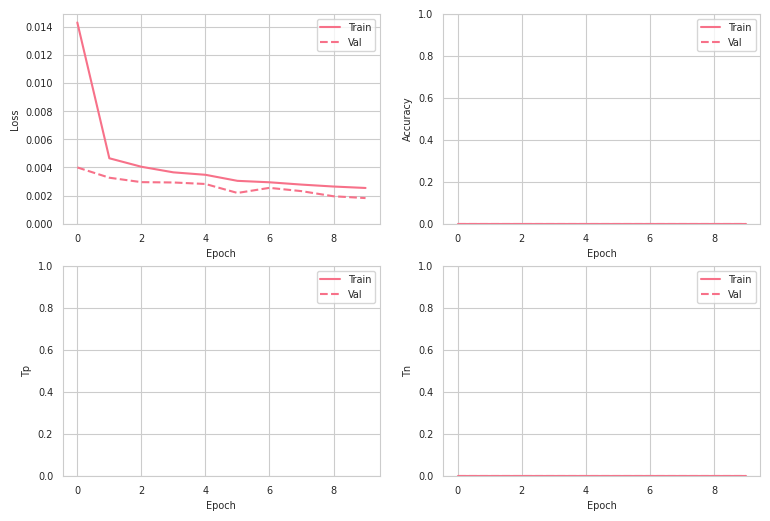

In [123]:
plot_metrics(history)

In [124]:
# conteúdo do history

history.history

{'loss': [0.014311949722468853,
  0.004655106924474239,
  0.0040519339963793755,
  0.0036539274733513594,
  0.003480259794741869,
  0.003049989230930805,
  0.002947187749668956,
  0.0027830242179334164,
  0.0026454529725015163,
  0.002542599570006132],
 'tp': [579.0, 564.0, 560.0, 554.0, 559.0, 558.0, 560.0, 559.0, 558.0, 556.0],
 'fp': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'tn': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'fn': [2273.0,
  2288.0,
  2292.0,
  2298.0,
  2293.0,
  2294.0,
  2292.0,
  2293.0,
  2294.0,
  2296.0],
 'accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'precision': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'recall': [0.20301543176174164,
  0.19775596261024475,
  0.19635343551635742,
  0.19424964487552643,
  0.1960028111934662,
  0.19565217196941376,
  0.19635343551635742,
  0.1960028111934662,
  0.19565217196941376,
  0.1949509084224701],
 'auc': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'mse': [0.014

## Análises dos resultados

In [125]:
# nem todas as métricas serão aplicadas a esse estudo!

results = rnn.evaluate(X_test, y_test)
for name, value in zip(rnn.metrics_names, results):
    print(name, ': ', value)
print()

28/28 [==============================] - 0s 4ms/step - loss: 0.0211 - tp: 473.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 408.0000 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.5369 - auc: 0.0000e+00 - mse: 0.0211 - mae: 0.0867 - rmse: 0.1451 - mspe: 0.0328
loss :  0.021054057404398918
tp :  473.0
fp :  0.0
tn :  0.0
fn :  408.0
accuracy :  0.0
precision :  1.0
recall :  0.536889910697937
auc :  0.0
mse :  0.021054057404398918
mae :  0.08672693371772766
rmse :  0.1451001614332199
mspe :  0.03281876817345619



### Pontuação F1, ACC Score, CM
* Se a RNN estiver sendo usada para resolver um problema de classificação binária (por exemplo, prever se uma sequência pertence a uma determinada classe ou não), a pontuação F1 pode ser uma métrica importante para avaliar o desempenho do modelo. Isso ocorre porque a precisão e o recall são duas medidas importantes que podem afetar significativamente o desempenho do modelo em diferentes situações.
* Nesse caso, como vemos, uma métrica que não aplica a esse problema estudado!

In [126]:
# Fazer previsões e calcular métricas
y_pred = rnn.predict(X_test)
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Calcular as métricas de avaliação
acc_score = accuracy_score(np.sign(y_test_orig - np.roll(y_test_orig, 1))[1:], 
                           np.sign(y_pred_orig - np.roll(y_test_orig, 1))[1:])

f1 = f1_score(np.sign(y_test_orig - np.roll(y_test_orig, 1))[1:], 
              np.sign(y_pred_orig - np.roll(y_test_orig, 1))[1:], average='macro')

cm = confusion_matrix(np.sign(y_test_orig - np.roll(y_test_orig, 1))[1:], 
                      np.sign(y_pred_orig - np.roll(y_test_orig, 1))[1:])

# Imprimir as métricas de avaliação
print('Accuracy score:', acc_score)
print('F1 score:', f1)
print('Confusion matrix:\n', cm)

28/28 [==============================] - 0s 3ms/step
Accuracy score: 0.5238636363636363
F1 score: 0.34070008753553055
Confusion matrix:
 [[307   0 173]
 [  1   0   6]
 [239   0 154]]


## Conclusão

Neste exemplo, consegue-se perceber a importancia das métricas e, principalmente, das suas escolhas. 

Vale um estudo detalhado sobre as configurações possíveis da RNN utilizada, alterando-se as funções de ativação, números de neurônios, épocas e normalização.

Sobre os resultados, vemos que as séries ficaram muito próximas. No entando, não se deve utilizar esse modelo para tomada de decisão sobre investimentos. 